In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import re
import pandas_profiling
import scipy.stats
import nltk
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,classification_report, plot_roc_curve
from statsmodels.api import OLS
from collections import defaultdict
from sklearn.base import clone

from sklearn.naive_bayes import MultinomialNB
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = 15, 15
plt.style.use('bmh')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/LargeMovieReviewDataset.csv"
df = pd.read_csv(path)
pd.set_option('max_colwidth', 400)
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regard...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the ref...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Paren...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action t...",positive


In [ ]:
pip install wordcloud

In [ ]:
SEED = 42;
TARGET = "sentiment"

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Exactly 50000 reviews and all of them are marked. Let's check sentiment distribution 

In [ ]:
df[TARGET].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

Perfectly balanced clasess, which is very nice since some unbalanced class problems.

#1. Text Preprocessing

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), df[TARGET], 
                                                  random_state=SEED, shuffle=True, stratify = df[TARGET], test_size = 0.25)

In [ ]:
X_train.head()

,review
17949,I just saw Adam Had Four Sons for the first time and the thing that struck me was that I believe that the model used was Theodore Roosevelt and his four sons. They were approximately the same ages as the four boys in this film. Warner Baxter in his portrayal of Adam Stoddard talked about the same values and family tradition that you would have heard from our 26th president without some of the ...
5786,"I for one have shamelessly enjoyed every episode of Pushing Daisies this season, and hope that the writers' strike won't brutally end the beginnings of a very good show. Ned is a pie maker who owns a restaurant in the middle of town and has a secret talent. Emmerson is a private investigator with his own unique quirks like his love of knitting. Charlotte (Chuck) is the once-dead-but-not-anymor..."
42175,"This movie is a journey through the mind of a screenwriter caught in his own paradoxical philosophy. He examines the ever illusive question of 'who am I' and 'what is I?' It's a courageous and thought provoking enterprise. There is a shipload of beautiful images, dream-inspired, Escher-like paradoxes reminiscent of the hand drawing itself, or rather, erasing itself. More and more we follow the..."
39484,"This was absolutely one of the best movies I've seen. <br /><br />Excellent performances from a marvelous A-List cast that will move you from smiles to laughter to tears and back.<br /><br />I couldn't help but care about the characters. Ms. Merkerson will blow you away, as will the young man playing the young lead.<br /><br />I also thought that the set design was top-rate. The viewer is real..."
34209,"Oh Geez... There are so many other films I want to see out there... I got stuck with my nephew for the weekend and this is what he wanted - Yeah...<br /><br />I used to watch this show when I was in college...it was mindless, kinda fun, and somewhat action-oriented. The show had a good heart tho...and the characters were cute; no one ever got killed or even hurt badly... it was like a cartoon ..."


## 1.1 Cleaning and tokenization

In [ ]:
#Remove URLS
def clean_URL(text):
  return re.sub(r'https?://\S+', '',text) 

In [ ]:
#Clean tags like <br>
def clean_HTML(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
#Remove special characters using regex
def clean_special(text):
  #simple one -- just letters and numbers are allowed
  return re.sub('[^a-zA-Z0-9]+', ' ',text) 

In [ ]:
#lowercasing text
def to_lower(text):
  return [token.lower() for token in text]

In [ ]:
X_train["review"] = X_train["review"].apply(clean_URL)
X_train["review"] = X_train["review"].apply(clean_HTML)

#Using tokenizer BEFORE cleaning special charecters dont differs much -- they
#both cant handle smth like "won't" and split it in 2 words
X_train["review"] = X_train["review"].apply(clean_special)

In [ ]:
#nltk tokenization
X_train["review"] = X_train["review"].apply(word_tokenize)

It is adviced to lowercase text *after* tokenization, since uppercase can be usefull for tokenization

In [ ]:
X_train["review"] = X_train["review"].apply(to_lower)

Let's have a look on the result after cleaning

In [ ]:
X_train.head()

,review
17949,"[i, just, saw, adam, had, four, sons, for, the, first, time, and, the, thing, that, struck, me, was, that, i, believe, that, the, model, used, was, theodore, roosevelt, and, his, four, sons, they, were, approximately, the, same, ages, as, the, four, boys, in, this, film, warner, baxter, in, his, portrayal, of, adam, stoddard, talked, about, the, same, values, and, family, tradition, that, you,..."
5786,"[i, for, one, have, shamelessly, enjoyed, every, episode, of, pushing, daisies, this, season, and, hope, that, the, writers, strike, won, t, brutally, end, the, beginnings, of, a, very, good, show, ned, is, a, pie, maker, who, owns, a, restaurant, in, the, middle, of, town, and, has, a, secret, talent, emmerson, is, a, private, investigator, with, his, own, unique, quirks, like, his, love, of,..."
42175,"[this, movie, is, a, journey, through, the, mind, of, a, screenwriter, caught, in, his, own, paradoxical, philosophy, he, examines, the, ever, illusive, question, of, who, am, i, and, what, is, i, it, s, a, courageous, and, thought, provoking, enterprise, there, is, a, shipload, of, beautiful, images, dream, inspired, escher, like, paradoxes, reminiscent, of, the, hand, drawing, itself, or, ra..."
39484,"[this, was, absolutely, one, of, the, best, movies, i, ve, seen, excellent, performances, from, a, marvelous, a, list, cast, that, will, move, you, from, smiles, to, laughter, to, tears, and, back, i, couldn, t, help, but, care, about, the, characters, ms, merkerson, will, blow, you, away, as, will, the, young, man, playing, the, young, lead, i, also, thought, that, the, set, design, was, top,..."
34209,"[oh, geez, there, are, so, many, other, films, i, want, to, see, out, there, i, got, stuck, with, my, nephew, for, the, weekend, and, this, is, what, he, wanted, yeah, i, used, to, watch, this, show, when, i, was, in, college, it, was, mindless, kinda, fun, and, somewhat, action, oriented, the, show, had, a, good, heart, tho, and, the, characters, were, cute, no, one, ever, got, killed, or, ev..."


Result is pretty good apart "won't" --> "won","t" problem, but this is expected output and most of it will be cleaned during stopword removing.

Since we got words, let's fiter out stopwords now

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def clean_stopwords(text,stopwords):
  
  return [token for token in text if token not in (stopwords)]

In [ ]:
X_train["review"] = X_train["review"].apply(clean_stopwords, args=(stopwords.words("english"),))

In [ ]:
X_train['review']

17949    [saw, adam, four, sons, first, time, thing, struck, believe, model, used, theodore, roosevelt, four, sons, approximately, ages, four, boys, film, warner, baxter, portrayal, adam, stoddard, talked, values, family, tradition, would, heard, 26th, president, without, boisterous, aspects, tr, character, like, tr, stoddard, sons, serve, world, war, case, though, youngest, loses, eye, instead, killed...
5786     [one, shamelessly, enjoyed, every, episode, pushing, daisies, season, hope, writers, strike, brutally, end, beginnings, good, show, ned, pie, maker, owns, restaurant, middle, town, secret, talent, emmerson, private, investigator, unique, quirks, like, love, knitting, charlotte, chuck, dead, anymore, childhood, friend, sunny, spot, ned, life, olive, jealous, good, hearted, waitress, oh, add, do...
42175    [movie, journey, mind, screenwriter, caught, paradoxical, philosophy, examines, ever, illusive, question, courageous, thought, provoking, enterprise, shipload, beautiful, im

Let's combine our cleaning functions in one, for convinience.

In [ ]:
def unite_cleaning(text):
 text = text.apply(clean_URL);
 text = text.apply(clean_HTML);
 text = text.apply(clean_special);
 text = text.apply(word_tokenize);
 text = text.apply(to_lower);
 text = text.apply(clean_stopwords, args=(stopwords.words("english"),));
 return text


##1.2 Normalization

Stemming vs Lemmatization approach.


### 1.2.1 Stemmer


As stemmer SnowBall stemmer is used, since it is belived to be upgraded version of Porter one. 

In [ ]:
stemmer = SnowballStemmer("english");

In [ ]:
def stem(text):
  return [stemmer.stem(token) for token in text]

In [ ]:
X_tr_stem = X_train["review"].apply(stem)

In [ ]:
X_tr_stem.head()

17949    [saw, adam, four, son, first, time, thing, struck, believ, model, use, theodor, roosevelt, four, son, approxim, age, four, boy, film, warner, baxter, portray, adam, stoddard, talk, valu, famili, tradit, would, heard, 26th, presid, without, boister, aspect, tr, charact, like, tr, stoddard, son, serv, world, war, case, though, youngest, lose, eye, instead, kill, femal, minx, get, male, household...
5786     [one, shameless, enjoy, everi, episod, push, daisi, season, hope, writer, strike, brutal, end, begin, good, show, ned, pie, maker, own, restaur, middl, town, secret, talent, emmerson, privat, investig, uniqu, quirk, like, love, knit, charlott, chuck, dead, anymor, childhood, friend, sunni, spot, ned, life, oliv, jealous, good, heart, waitress, oh, add, dog, jim, dale, bring, charact, togeth, w...
42175    [movi, journey, mind, screenwrit, caught, paradox, philosophi, examin, ever, illus, question, courag, thought, provok, enterpris, shipload, beauti, imag, dream, inspir, esch

### 1.2.2 Lemmatization 

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize(text):
  return [lemmatizer.lemmatize(token) for token in text]

In [ ]:
X_tr_lem = X_train["review"].apply(lemmatize)

In [ ]:
X_train["review"].head()

17949    [saw, adam, four, sons, first, time, thing, struck, believe, model, used, theodore, roosevelt, four, sons, approximately, ages, four, boys, film, warner, baxter, portrayal, adam, stoddard, talked, values, family, tradition, would, heard, 26th, president, without, boisterous, aspects, tr, character, like, tr, stoddard, sons, serve, world, war, case, though, youngest, loses, eye, instead, killed...
5786     [one, shamelessly, enjoyed, every, episode, pushing, daisies, season, hope, writers, strike, brutally, end, beginnings, good, show, ned, pie, maker, owns, restaurant, middle, town, secret, talent, emmerson, private, investigator, unique, quirks, like, love, knitting, charlotte, chuck, dead, anymore, childhood, friend, sunny, spot, ned, life, olive, jealous, good, hearted, waitress, oh, add, do...
42175    [movie, journey, mind, screenwriter, caught, paradoxical, philosophy, examines, ever, illusive, question, courageous, thought, provoking, enterprise, shipload, beautiful, im

In [ ]:
X_tr_lem.head()

17949    [saw, adam, four, son, first, time, thing, struck, believe, model, used, theodore, roosevelt, four, son, approximately, age, four, boy, film, warner, baxter, portrayal, adam, stoddard, talked, value, family, tradition, would, heard, 26th, president, without, boisterous, aspect, tr, character, like, tr, stoddard, son, serve, world, war, case, though, youngest, loses, eye, instead, killed, femal...
5786     [one, shamelessly, enjoyed, every, episode, pushing, daisy, season, hope, writer, strike, brutally, end, beginning, good, show, ned, pie, maker, owns, restaurant, middle, town, secret, talent, emmerson, private, investigator, unique, quirk, like, love, knitting, charlotte, chuck, dead, anymore, childhood, friend, sunny, spot, ned, life, olive, jealous, good, hearted, waitress, oh, add, dog, ji...
42175    [movie, journey, mind, screenwriter, caught, paradoxical, philosophy, examines, ever, illusive, question, courageous, thought, provoking, enterprise, shipload, beautiful, im

Just due to the curiosity let's check difference in result spelling

In [ ]:
#printing tokens if they are different for both sides.
def difference(stem_text,lem_text,labelNames = ["Stemming", "Lemmatization"]):
  stem_spell = [];
  lem_spell = [];
  for idx,item in enumerate(stem_text):
    if item != lem_text[idx]:   #different spelling
      stem_spell.append(item);
      lem_spell.append(lem_text[idx]);

  result = pd.DataFrame();
  result[labelNames[0]] = stem_spell;
  result[labelNames[1]] = lem_spell;

  return result

In [ ]:
difference(X_tr_stem.iloc[0], X_tr_lem.iloc[0])

,Stemming,Lemmatization
0,believ,believe
1,use,used
2,theodor,theodore
3,approxim,approximately
4,portray,portrayal
...,...,...
57,togeth,together
58,fifti,fifty
59,will,willing
60,believ,believe


On this example it's clear that the result of lemmatization is not that good as it was expected. "Used" isn't translated to "use", "cutting" kept its "-ing" part, which is also incorrect
To fix that, we need to specify specifying POS-tags in WordNet. NLTK has built-in function pos_tag, but POS-tags WordNet is ussing has different type.
Let's create dictionary to convert POS tags

In [ ]:
# since default tag is NOUN, we can use default dict

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [ ]:
def pos_lemmatize(text):
    return [lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(text)]


In [ ]:
X_tr_poslem = X_train['review'].apply(pos_lemmatize)

In [ ]:
difference(X_tr_poslem.iloc[0], X_tr_lem.iloc[0], labelNames = ["Lemm. with POS tags", "Old Lemm."])

,Lemm. with POS tags,Old Lemm.
0,strike,struck
1,use,used
2,hear,heard
3,young,youngest
4,kill,killed
5,early,earliest
6,make,making
7,bring,brought
8,portray,portrays
9,go,going


This result is much better now

### Word importance

Function to plot beatifull word-importance plot. 
It takes coefficient and feature names, sort it for coef. and print top 30 results

In [ ]:
def plot_importance(values,names):
  zipped = zip(names, values);

  #sort for values
  res = sorted(zipped, key = lambda x: abs(x[1]),reverse=True)[:30]

  #resort to achive correct oreder 
  res = sorted(res, key = lambda x: x[1],reverse=True)
  
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  ax = sns.barplot(x = [val[1] for val in res], y = [val[0] for val in res], palette=['r' if val[1] > 0 else 'b' for val in res])
  ax.set(xlabel='importance', ylabel='Word')
  ax.set_title("Top 30 (abs) important words",fontsize=22)

# 2.  Models

Since sk-learn TF-IDF expect text as input, we need to revert tokenizer, otherwise it will condiser each token as separate document :(

## 2.1 Using Lemmatized text

In [ ]:
tfidf = TfidfVectorizer(lowercase=False);
dtnk = TreebankWordDetokenizer();

In [ ]:
X_tr_lem = X_tr_poslem.apply(dtnk.detokenize)
X = tfidf.fit_transform(X_tr_lem)

In [ ]:
#test preporation
X_test_cln = unite_cleaning(X_test["review"])  #clean
X_test_lem = X_test_cln.apply(pos_lemmatize)   #lemmatize
X_test_lem = X_test_lem.apply(dtnk.detokenize) #detokenize
X_test_lem = tfidf.transform(X_test_lem)       #vectorize


### SGDClassifier

In [ ]:
SGDmodel = SGDClassifier();
SGDmodel.fit(X,y_train);

In [ ]:
y_pred = SGDmodel.predict(X_test_lem)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.87      0.89      6250
    positive       0.88      0.91      0.90      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



Since there is LinearSVM (non-linear kernels take too much time to learn) there is no sense making *hinge-loss* since these classifier will use same loss function. Therefore log-loss is used, making this logistic regression.

In [ ]:

params = {'loss': ['log','hinge'], 'penalty':['l2', 'l1', 'elasticnet'],'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}
grid = GridSearchCV(SGDmodel,params,cv=5)
grid.fit(X, y_train)
y_pred = grid.predict(X_test_lem)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                         'loss': ['log', 'hinge'],
                         'penalty': [

In [ ]:
SGDmodel = grid.best_estimator_;

In [ ]:
grid.best_params_

{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}

best params are default params :(

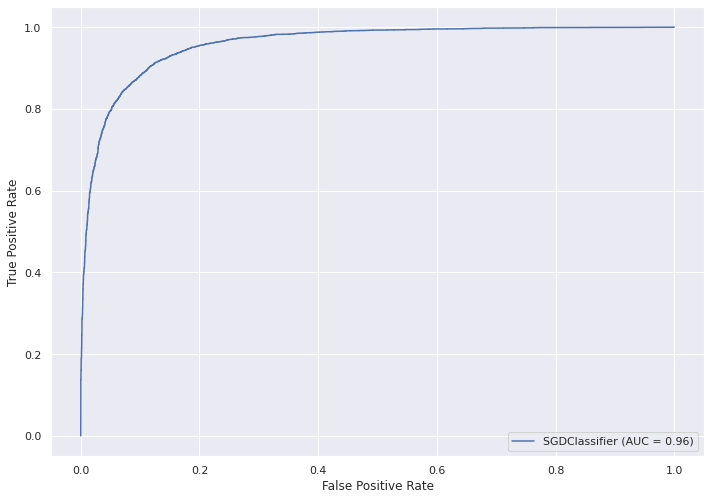

In [ ]:

plot_roc_curve(SGDmodel, X_test_lem, y_test)

Seems like log-loss performs same as hinge with default params.

### SVM

In [ ]:
SVCmodel = LinearSVC();

params = {'loss': ["hinge", "squared_hing"], 'penalty':['l2', 'l1'],'C': [0.01,0.1, 0.5, 1, 2, 5,10],'dual':[True,False]}
grid = GridSearchCV(SVCmodel,params,cv=5)
grid.fit(X, y_train)
y_pred = grid.predict(X_test_lem);


In [ ]:
SVCmodel = grid.best_estimator_
print(grid.best_params_)

{'C': 0.5, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}


In [ ]:
y_pred = SVCmodel.predict(X_test_lem)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      6250
    positive       0.89      0.91      0.90      6250

    accuracy                           0.89     12500
   macro avg       0.90      0.89      0.89     12500
weighted avg       0.90      0.89      0.89     12500



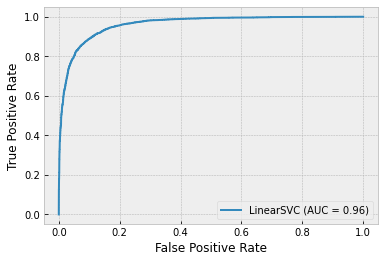

In [ ]:
plot_roc_curve(SVCmodel,X_test_lem,y_test)

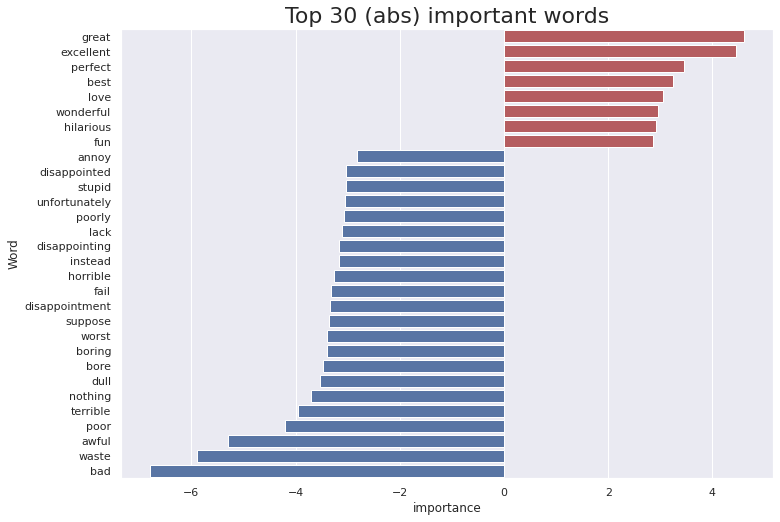

In [ ]:
plot_importance(SVCmodel.coef_[0],tfidf.get_feature_names())

### Naive Bayes

In [ ]:
#MultinominalNB is know to work well with CountVectorizer, but TF-IDF also works
NBmodel = MultinomialNB();

params = {'alpha':[1, 1e-1, 1e-2,1e1,1e2]}
grid = GridSearchCV(NBmodel,params,cv=5)
grid.fit(X, y_train)
y_pred = grid.predict(X_test_lem);

In [ ]:
NBmodel = grid.best_estimator_

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      6250
    positive       0.87      0.85      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



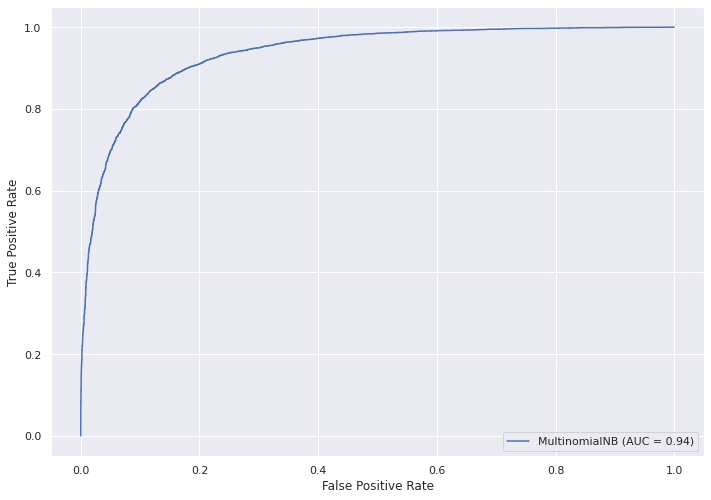

In [ ]:
plot_roc_curve(NBmodel,X_test_lem,y_test)

### Model Compare

Text(0.5, 1.0, 'Model Compare (Lemmatizer)')

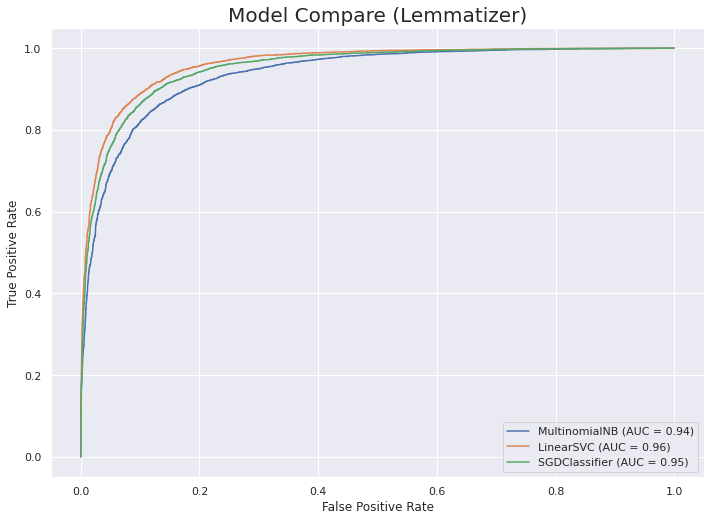

In [ ]:

ax = plt.gca()

for clf in [NBmodel,SVCmodel,SGDmodel]:
  plot_roc_curve(clf,X_test_lem,y_test,ax=ax);
ax.set_title("Model Compare (Lemmatizer)",fontsize=20)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      6250
    positive       0.87      0.85      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [ ]:
model = grid.best_estimator_

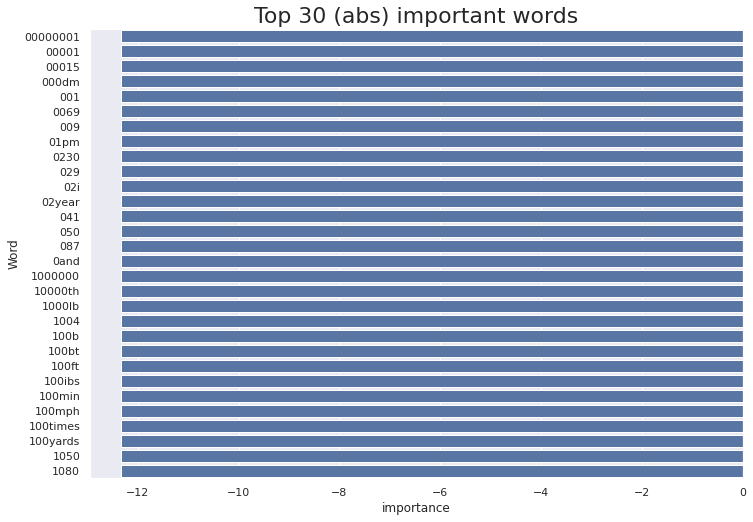

In [ ]:
plot_importance(model.coef_[0],tfidf.get_feature_names())

## 2.2 Using Stemmed text

In [ ]:
tfidf_stm = TfidfVectorizer(lowercase=False);
X_stem = X_tr_stem.apply(dtnk.detokenize)
X_stem = tfidf_stm.fit_transform(X_stem)

In [ ]:
X_test_stm = X_test_cln.apply(stem)
X_test_stm = X_test_stm.apply(dtnk.detokenize)
X_test_stm = tfidf_stm.transform(X_test_stm)

### SGD

In [ ]:
SGDmodel.fit(X_stem,y_train);
y_pred = SGDmodel.predict(X_test_stm)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

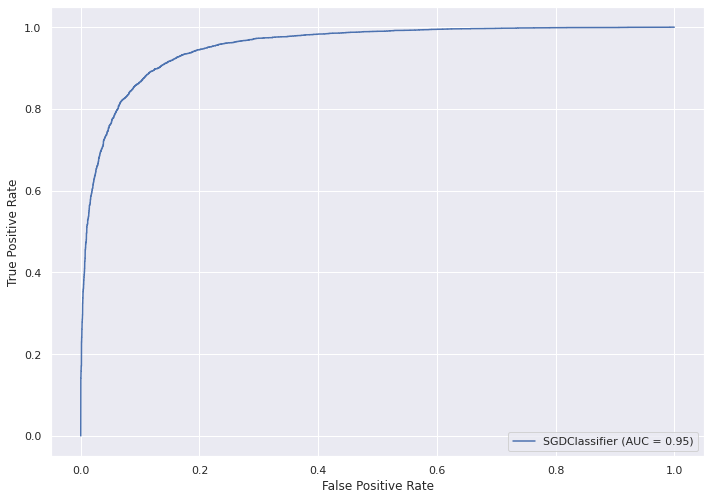

In [ ]:
plot_roc_curve(SGDmodel, X_test_stm, y_test)

### SVM

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

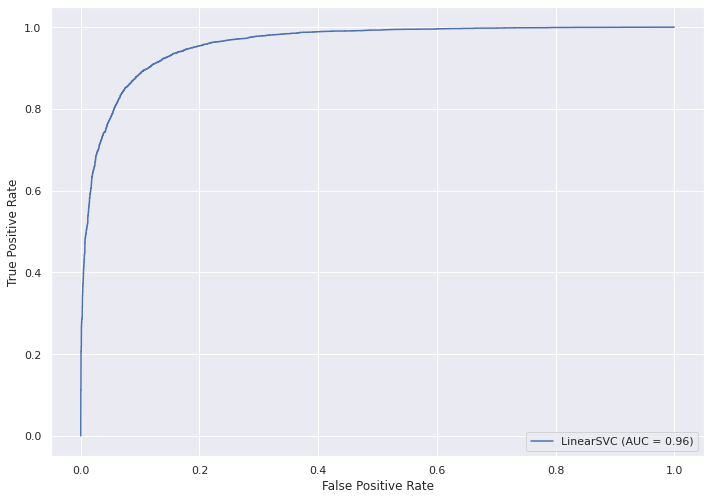

In [ ]:
SVCmodel = LinearSVC();
SVCmodel.fit(X_stem,y_train);
y_pred = SVCmodel.predict(X_test_stm);
plot_roc_curve(SVCmodel, X_test_stm, y_test)

###Naive Bayes

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

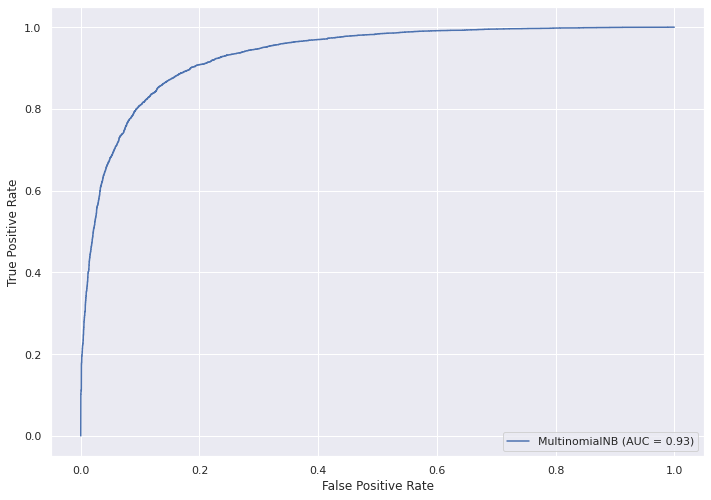

In [ ]:
NBmodel.fit(X_stem,y_train);
y_pred = NBmodel.predict(X_test_stm);
plot_roc_curve(NBmodel, X_test_stm, y_test)

### Model Compare

Text(0.5, 1.0, 'Model Compare (Stemmer)')

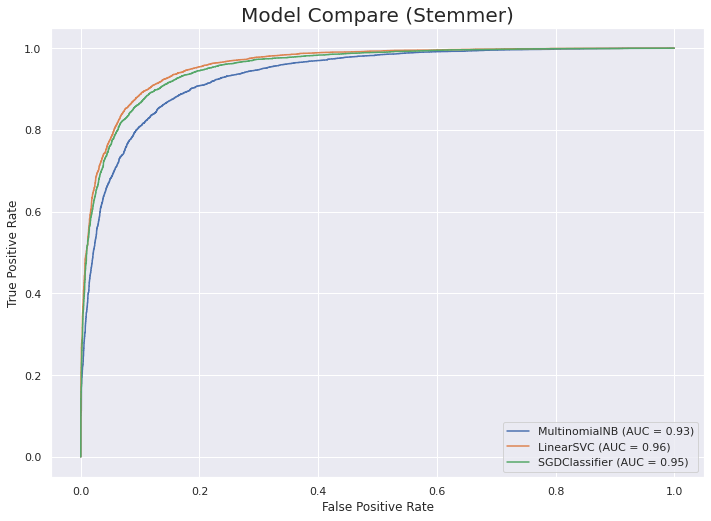

In [ ]:
ax = plt.gca()

for clf in [NBmodel,SVCmodel,SGDmodel]:
  plot_roc_curve(clf,X_test_stm,y_test,ax=ax);
ax.set_title("Model Compare (Stemmer)",fontsize=20)
test = ax

## Stemmer vs Lemmatization comparison

Using best model according to the results (linearSVC) let's compare on single ROC_AUC plot two methods


In [ ]:
#Stem model
SVC_stem = clone(SVCmodel);
SVC_stem.fit(X_stem,y_train);

#Lem. model
SVC_lem = clone(SVCmodel);
SVC_lem.fit(X,y_train);

Text(0.5, 1.0, 'Stem. vs Lem. LinearSVC ROC-AUC')

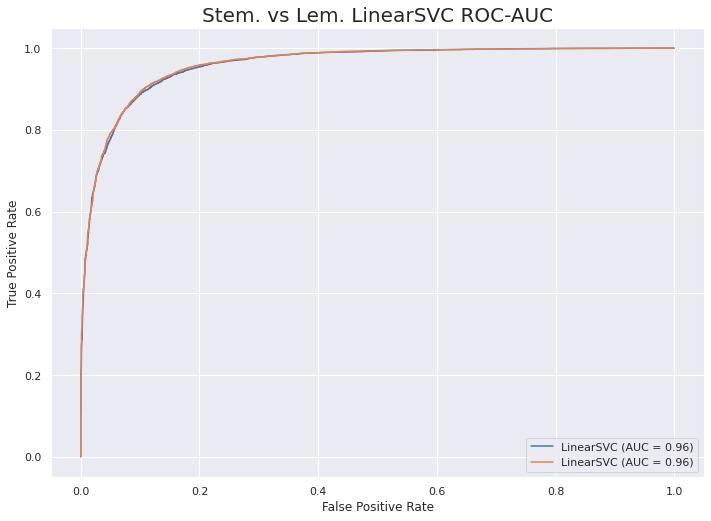

In [ ]:
ax = plt.gca()
plot_roc_curve(SVC_stem,X_test_stm,y_test,ax=ax);
plot_roc_curve(SVC_lem,X_test_lem,y_test,ax=ax);
ax.set_title("Stem. vs Lem. LinearSVC ROC-AUC",fontsize=20)

Let's compare top 30 words of this two methods

In [ ]:
#get stem top30
zip_stm = zip(SVC_stem.coef_[0], tfidf_stm.get_feature_names()) #make tuple -- (importance,word)
stem_top = sorted(zip_stm, key = lambda x: abs(x[0]), reverse=True)[:30]

#get lem. top30
zip_lem = zip(SVC_lem.coef_[0], tfidf.get_feature_names())
lem_top = sorted(zip_lem, key = lambda x: abs(x[0]), reverse=True)[:30]

#combine tops
res = pd.DataFrame();
res["Stem"] = [val[1] for val in stem_top]
res["Lemm"] = [val[1] for val in lem_top]
print(res)

          Stem            Lemm
0        worst           awful
1         wast           waste
2           aw             bad
3         poor           worst
4        excel       excellent
5   disappoint   disappointing
6      perfect            poor
7         bore  disappointment
8          bad           great
9         fail         perfect
10       great        horrible
11   brilliant            fail
12     horribl        terrible
13     terribl    disappointed
14        wors          poorly
15     forgett            bore
16     mediocr          boring
17     tedious        mediocre
18        save     forgettable
19     refresh         nothing
20      hilari       hilarious
21       enjoy       wonderful
22        noth            save
23      suppos       brilliant
24        lack          highly
25       annoy   unfortunately
26  uninterest            dull
27        dull           fails
28     favorit       enjoyable
29    unintent     wonderfully


As it seems, most important words chosen by the model are nearly from the same set of words, regardless of word-tranformation technique.

In [ ]:
#size of the vocabulary depending on method

print("Stem. vocab: ",len(tfidf_stm.get_feature_names()))
print("Lem. vocab: ",len(tfidf.get_feature_names()))

Stem. vocab:  62838
Lem. vocab:  80896


# 3. Detailed Conslusions








**1.   Stemming vs Lemmatization**


*   Model Perfomance -- Same numeric results (*AUC* and *accuracy*, 2 digits after comma format) on every model. ROC curve differs very slightly. 

*   Speed -- according to this VM results, lemmatizing using custom POS-tags takes 5 times more time than stemming (5 min to 1 min) 

*   Vocabulary -- after stemming, vocabulary is almost 25% smaller than lemmatization one.

Conclusion: in case of this dataset stemming is winner, it shows same accuracy result using less time and words. 
The only pary where lemmatization is better -- reading results. Words after lemmatization are understandable and readeble. (Unlike *"aw"* in Stemming, which most likely to be *awfull*, but it can be clear only using context)


**2.   Model comparison**


*   Model Perfomance -- all models shows decent results (~90% accuracy on test set), using AUC metric the best modal is SVM -- 0.96 (Linear kernel), same result has SGD, and the "worse" modal is Naive Bayes with 0.93 AUC. It's clear why SGD and SVM performs are close to each other, because gridsearch showed that best SGD hyperparameter is "hinge" making it same with LinearSVC.

*   Speed -- every model has shown decent result in term of fitting speed, but SVM with kernels other than Linear take more than an hour to learn and couldn't be used (This number is just boundary, exact number wasn't achieved)

Conclusion: for this dataset LinearSVC is best model, which was fast and most accurate.


**3.   List item**


Most important words are fully emotional related, there is no words making no-sence in top-features. Probably this work could be optimized using polar dictionaries which contains antonyms, which can be helpful in classifying senteiment. 
Also fun fact that among top 30 features there is more negative words than positives, which means people using small and specific vocabulary while criticizing, and bigger one, while praising something.

# 4. Some extra stuff

## Logistic Regression (*)

Since best classifier in SGD is "hinge" let's try another classifier with log loss function

In [ ]:
model = LogisticRegression();
model.fit(X,y_train);

In [ ]:
params = {'C': [0.05, 0.1, 1, 2.5, 5,10]}
grid = GridSearchCV(model,params,cv=5)
grid.fit(X, y_train)
y_pred = grid.predict(X_test_lem)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.05, 0.1, 1, 2.5, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Word Cloud

In [ ]:
corpus = X_tr_poslem.apply(clean_stopwords, args=(["movie","film",'saw','watch','one','time','see',"say","make"],));

In [ ]:
Text = corpus.apply(dtnk.detokenize)

In [ ]:
positive = Text.loc[y_train=="positive"]
negative = Text.loc[y_train=="negative"]

In [ ]:
positive

5786     shamelessly enjoy every episode push daisy season hope writer strike brutally end beginning good show ned pie maker own restaurant middle town secret talent emmerson private investigator unique quirk like love knit charlotte chuck dead anymore childhood friend sunny spot ned life olive jealous good hearted waitress oh add dog jim dale bring character together wonderful narration show chuck ned...
42175    journey mind screenwriter catch paradoxical philosophy examines ever illusive question courageous think provoke enterprise shipload beautiful image dream inspire escher like paradox reminiscent hand draw rather erase follow writer agony phone wife leave peru leave take care baby task perform less less attention absorb dilemma hardly look child anymore wife come back scene destroys note help go...
39484                                      absolutely best excellent performance marvelous list cast move smile laughter tear back help care character ms merkerson blow away young ma

Combine 

In [ ]:
positive_text = " ".join(row.split()[1] for row in positive)
negative_text = " ".join(row.split()[1] for row in negative)

In [ ]:
neg_cloud = WordCloud(collocations = False, background_color = 'white').generate(negative_text)
pos_cloud = WordCloud(collocations = False, background_color = 'white').generate(positive_text)

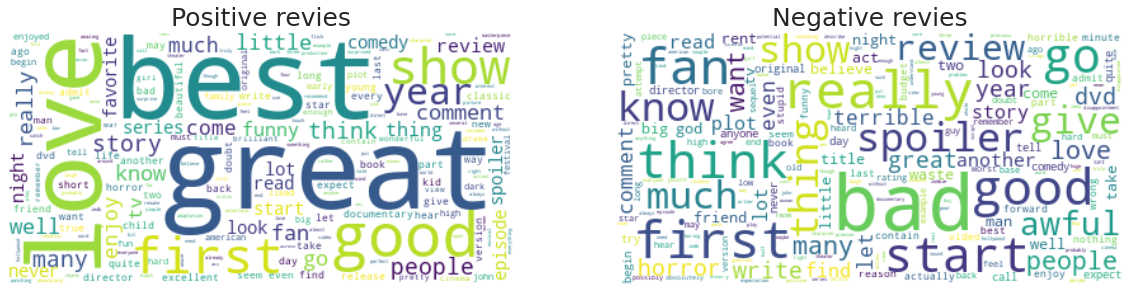

In [ ]:
#plot both WordClouds on same plot

f, axarr = plt.subplots(nrows=1,ncols=2,figsize=(20,20));

plt.sca(axarr[0]); 
plt.axis('off')
plt.imshow(pos_cloud, interpolation='bilinear'); plt.title('Positive revies',fontsize=25);
plt.sca(axarr[1]); 
plt.axis('off')
plt.imshow(neg_cloud, interpolation='bilinear'); plt.title('Negative revies',fontsize=25);
